# Claims Amount Prediction

This notebook presents a solution for Loss Ratio Prediction using data from a French automotive insurance company, which includes risk characteristics and claim information related to motor liability insurance contracts. The objective is to predict the annual claims amount per customer based on the features provided in the dataset.

## Setup

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Cleaning
import pandas as pd
import numpy as np
import arff

# Exploratory Data Analysis
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

# Feature Engineering & Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# Model Selection and Validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import torch


### Data Loading

Let's start by loading the data and taking a look at the first rows of both datasets

In [54]:
# Loading the frequency data
data_freq = arff.load('data/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])

df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


In [3]:
# Loading the severity data
data_sev = arff.load('freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

df_sev.head()

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


In [53]:
# Checking the number of non-unique policies in the frequency and severity datasets
print(f"{round(1 - df_sev['IDpol'].nunique() / len(df_sev), 3) * 100} % of the policies in the severity dataset have more than one claim.")

6.3 % of the policies in the severity dataset have more than one claim.


### Merging the datasets

We will merge the datasets on the `IDpol` column, which is the unique identifier for each customer. However, first we need to aggregate the claim dataset to have only one row per customer, with the sum of the claims amount. Some claims from the severity dataset can not be merged, as they are not present in the frequency dataset. We will ignore these observations as we do not have any data for them.

In [5]:
# Add all claim amounts for each policy
df_sev_grouped = df_sev.groupby('IDpol').sum().reset_index()
print("After grouping the severity dataset by policy, the number of unique policies is: ", df_sev_grouped['IDpol'].nunique())

After grouping the severity dataset by policy, the number of unique policies is:  24950


In [6]:
# Merge the frequency and severity datasets
df = pd.merge(df_freq, df_sev_grouped, on='IDpol', how='left')

In [7]:
# get the observations which are in df_sev but not in merged df - aka the unmatched observations
print(f"Number of not matached observations with grouped severity data: {len(df_sev_grouped[~df_sev_grouped['IDpol'].isin(df['IDpol'])])}")

Number of not matached observations with grouped severity data: 6


In [8]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',NaN
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',NaN
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',NaN
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',NaN
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',NaN


In [ ]:
# safe the merged data for easy access later
df.to_csv('merged_data.csv', index=False)

## Data Cleaning

In this step, we will clean the data by checking for missing values and removing unnecessary columns. We will also check for duplicated rows and remove them if necessary. Further data preprocessing will be done in the next steps.

In [5]:
# Load the data
df = pd.read_csv('data/merged_data.csv')

In [11]:
# No need for IDpol column as it is just an index
df.drop(columns=['IDpol'], inplace=True)

# Build the target variable
df["LossRatio"] = df["ClaimAmount"] / df["Exposure"]

# No need for Exposure, ClaimNB, and ClaimAmount columns as they are part of the target variable
df.drop(columns=['Exposure', 'ClaimNb', 'ClaimAmount'], inplace=True)

In [12]:
# Check for missing values
df.isnull().sum()

Area               0
VehPower           0
VehAge             0
DrivAge            0
BonusMalus         0
VehBrand           0
VehGas             0
Density            0
Region             0
LossRatio     653069
dtype: int64

In [13]:
# The once having missing values in the LossRatio are the once with no claims - replace missing values with 0
df['LossRatio'].fillna(0, inplace=True)

In [6]:
# Check for duplicates
df.duplicated().sum()

0

## Exploratory Data Analysis

In this step, we will explore the data to understand the distribution of the features and the relationship between them. We first perform a univariate analysis to understand the distribution of the target variable and the features. Then, we perform a multivariate analysis to understand the relationship between the features and the target variable.

### Univariate Analysis

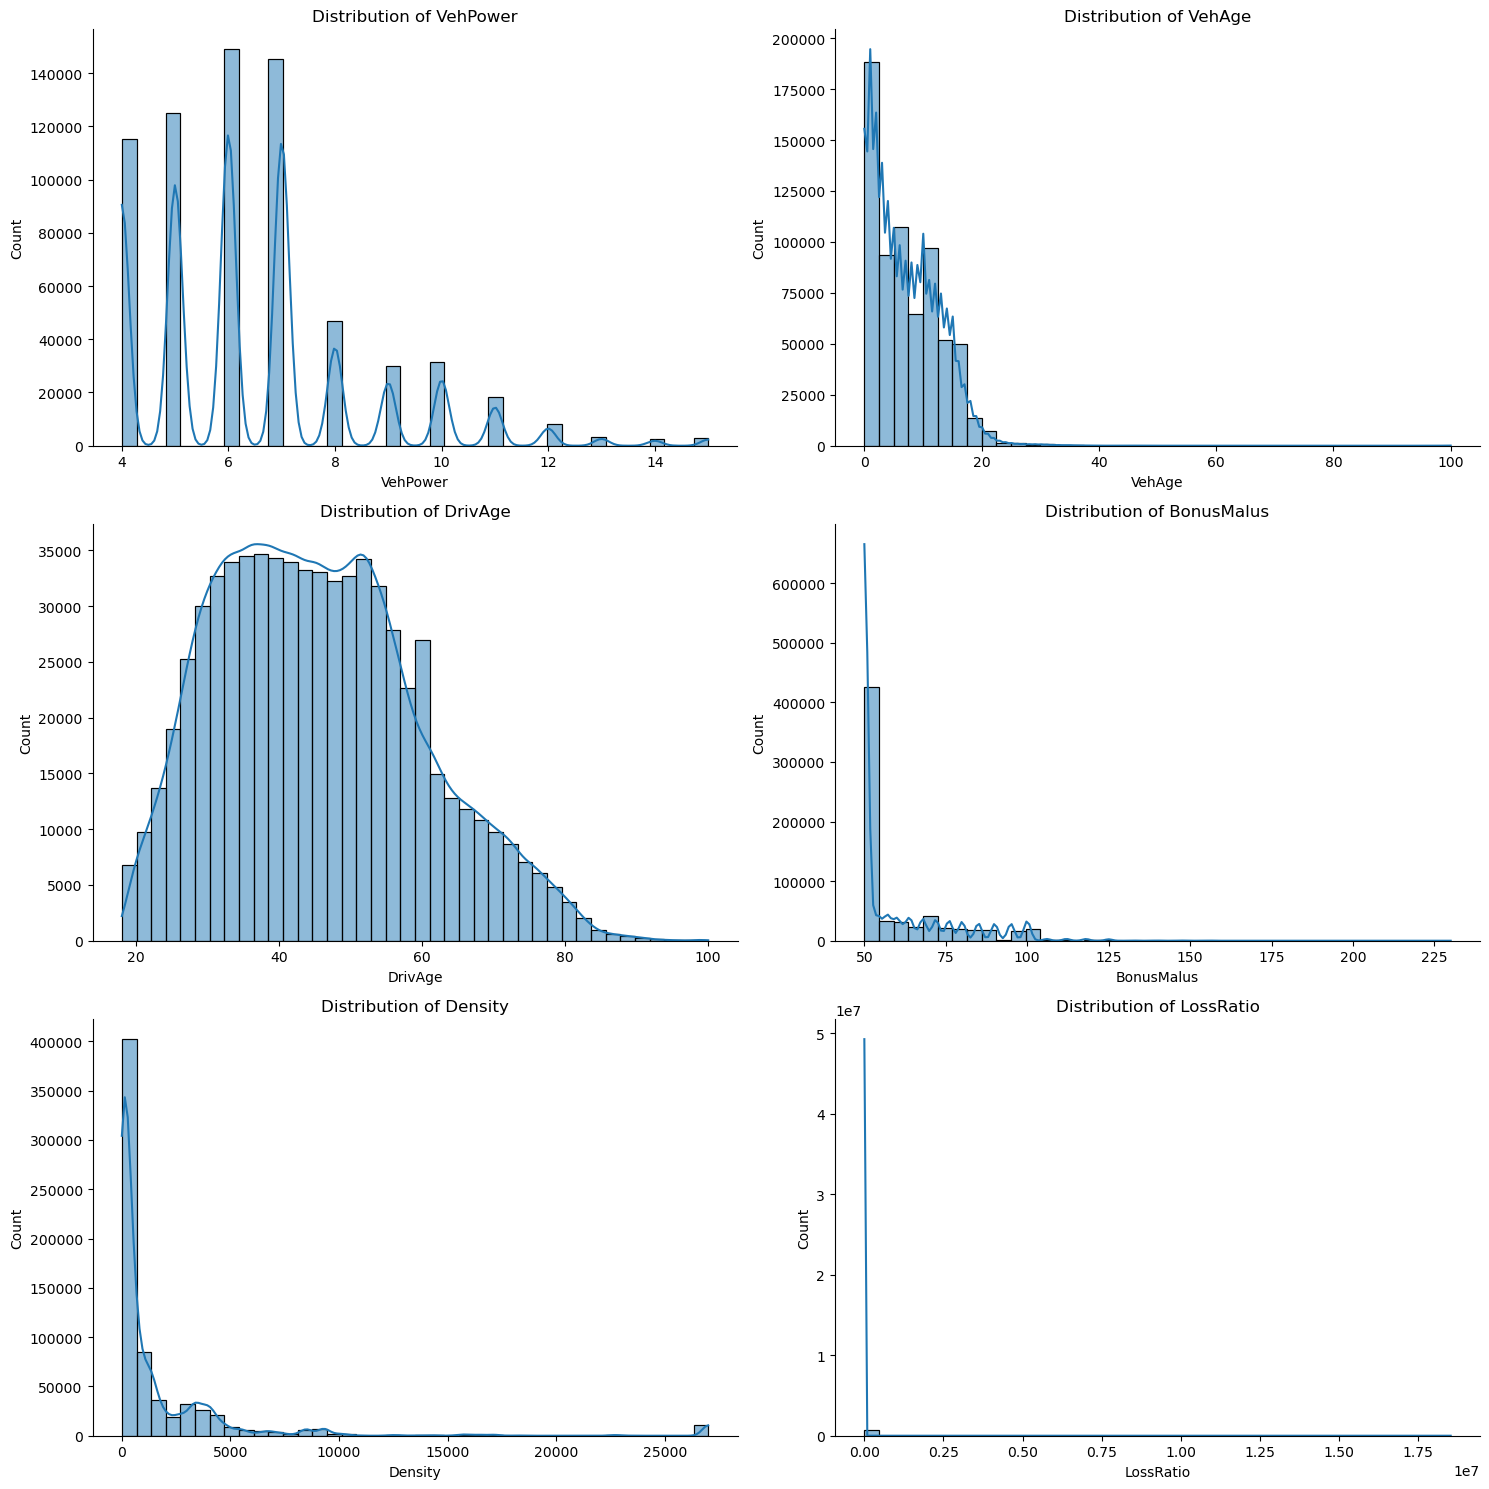

In [14]:
# Get numerical features
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
cat_vars = df.select_dtypes(include=['object']).columns

# Plot the distribution of numerical features
plt.figure(figsize=(15, 15)) 
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=df, x=column, kde=True, bins=40)
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

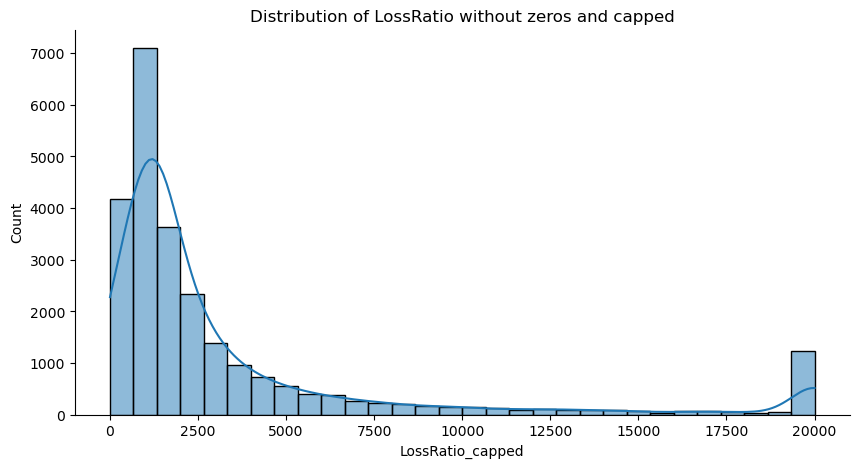

In [15]:
# plot the distribution of the target variable without the zeros
plt.figure(figsize=(10, 5))
# cap the LossRatio at 1000 to make the plot more readable and remove the zeros
df["LossRatio_capped"] = df["LossRatio"].apply(lambda x: 20000 if x > 20000 else x)
sns.histplot(data=df[df['LossRatio'] > 0]['LossRatio_capped'], kde=True, bins=30)


plt.title('Distribution of LossRatio without zeros and capped')
sns.despine()
plt.show()

# drop unnecessary column
df.drop(columns=['LossRatio_capped'], inplace=True)

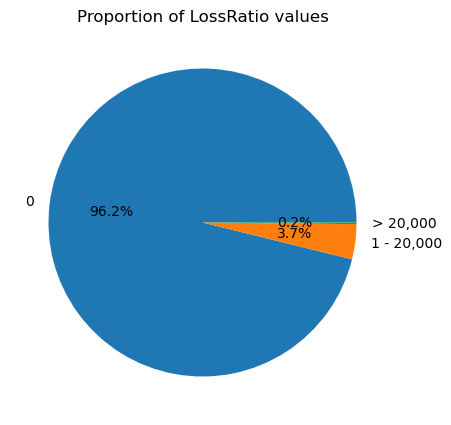

In [16]:

plt.figure(figsize=(10, 5))
plt.pie([len(df[df['LossRatio'] == 0]) / len(df), len(df[df['LossRatio'] > 0]) / len(df), len(df[df["LossRatio"] > 20_000]) / len(df)], labels=['0', '1 - 20,000', "> 20,000"], autopct='%1.1f%%')
plt.title('Proportion of LossRatio values')

plt.show()

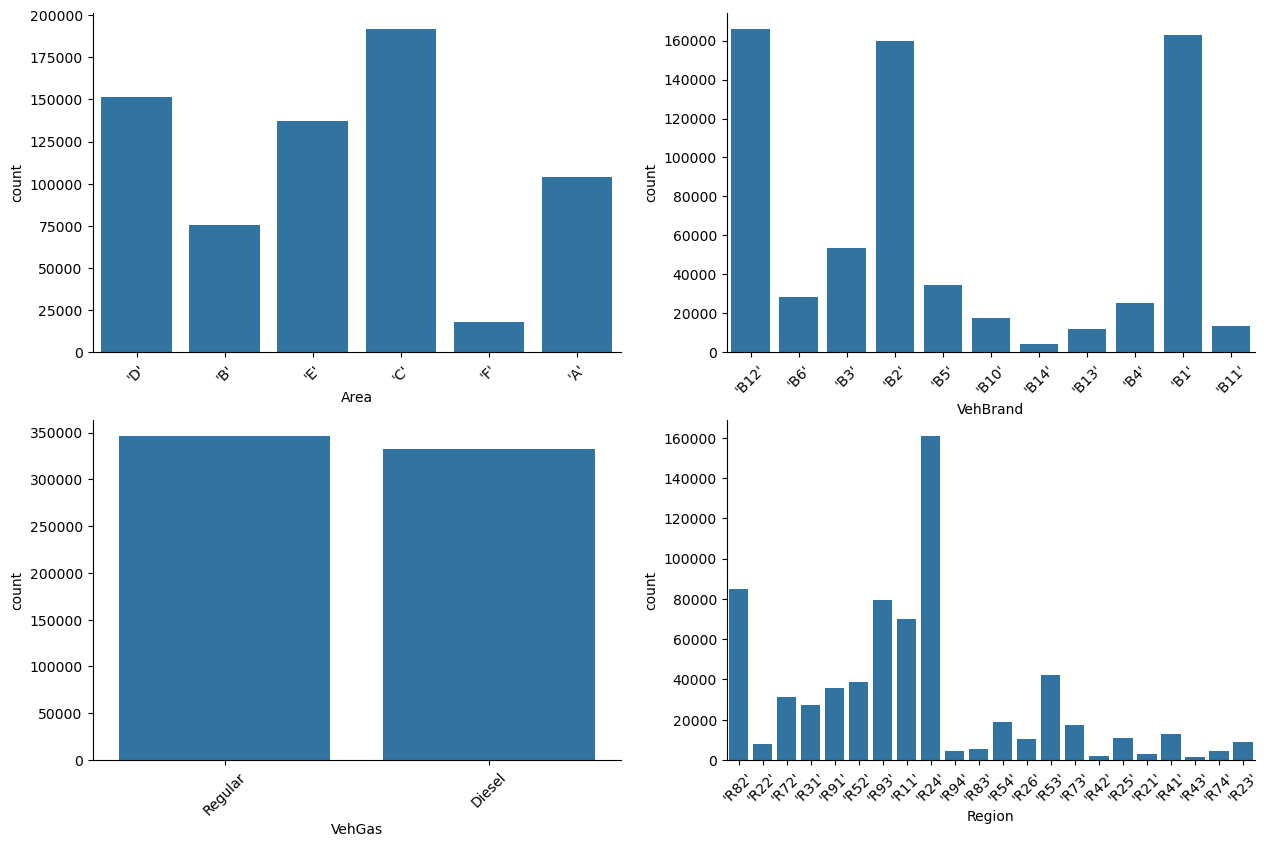

In [17]:
# Make univariate analysis for categorical variables
plt.figure(figsize=(15, 15))
for i, column in enumerate(cat_vars):
    plt.subplot(3, 2, i+1)
    sns.countplot(data=df, x=column)
    plt.xticks(rotation=45)
    sns.despine()

### Oberservations Univariate Analysis
1. A lot of features having non-normal distributions, which may require transformation.

2. Some features have outliers, which may need to be treated.

3. The Target variable is extremely right-skewed due to the fact that most customers do not have any claims. Furthermore, there are some customers with very high claims amount.
4. Binning could be used for some features to improve the model performance however as we mostly use tree-based methods this may not be necessary as these models are good in finding suiting splits.
5. The Region feature has a lot of categories, causing high-dimensional encoding. Grouping regions might be a good idea however we will keep it as it is for now as we use feature selection techniques that can handle high-dimensional encoding.
6. Some categories have very few observations, one could group them into a new category called "Other" to reduce the dimensionality of the feature.

### Multivariate Analysis

<Axes: >

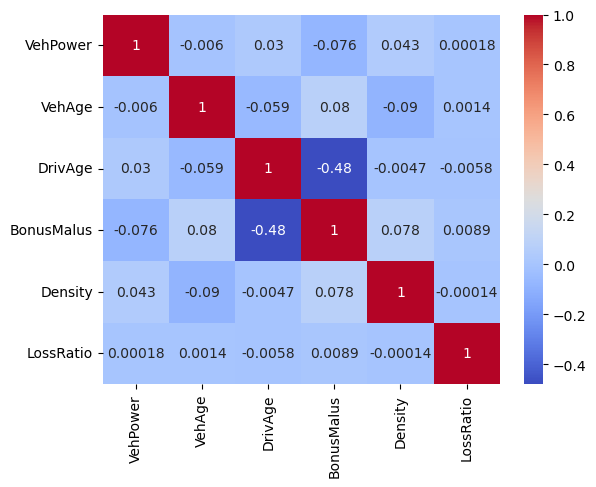

In [18]:
# Build the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

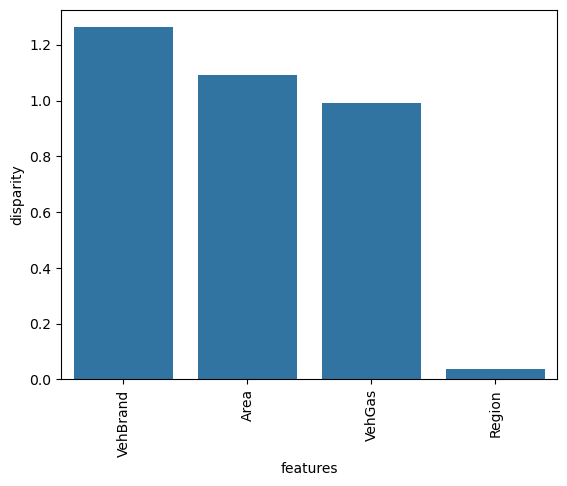

In [19]:
anv = pd.DataFrame()
anv['features'] = cat_vars
pvals = []

for c in cat_vars:
     samples = []
     for cls in df[c].unique():
           s = df[df[c] == cls]['LossRatio'].values
           samples.append(s)
     pval = stats.f_oneway(*samples)[1]
     pvals.append(pval)
     
anv['pval'] = pvals
anv['disparity'] = np.log(1. / anv['pval'].values)

anv = anv.sort_values(by='disparity',ascending=False)

sns.barplot(data=anv, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt.show() 

### Observations Multivariate Analysis

1. There are no clear linear correlations between the numerical features and the target variable which might make it hard to predict.

2. There is strong correlation between age and BonusMalus which is expected as older drivers tend to have lower BonusMalus values.
3. Region has a really low disparity in claims amount, which might make it a less important feature for the model. One could think of dropping it, especially since it has a high cardinality. However we still keep it and rather perform Feature Selection to see if it is important or not.

## Feature Engineering

In this step, we will create new features based on the existing ones. We will also encode the categorical features and scale the numerical features. Further an outlier analysis will be performed to detect outliers. Finally we use the feature importance of a simple Random Forrest Regressor to select the most important features.

### Creating new features

We will create new features based on the existing ones to improve the model performance. We will create the following features:

In [20]:
# Interactions
df['VehPower_VehAge'] = df['VehPower'] * df['VehAge']
df['DrivAge_BonusMalus'] = df['DrivAge'] * df['BonusMalus']

# Ratio features
df['VehPower/VehAge'] = np.where(df["VehAge"] != 0, df['VehPower'] / df['VehAge'], df["VehPower"])
df['DrivAge/VehPower'] = np.where(df["VehPower"] != 0, df['DrivAge'] / df['VehPower'], df["DrivAge"])

# Polynomial features
df['VehPower_squared'] = df['VehPower'] ** 2
df['VehAge_squared'] = df['VehAge'] ** 2
df['DrivAge_squared'] = df['DrivAge'] ** 2

# Aggregate features
df['Mean_BonusMalus_Area'] = df.groupby('Area')['BonusMalus'].transform('mean')
df['Mean_Density_Area'] = df.groupby('Area')['Density'].transform('mean')

# Update the column lists
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
cat_vars = df.select_dtypes(include=['object']).columns

### Splitting the data

We will split the data into training and testing sets to train and evaluate the model. We will use 80% of the data for training and 20% for testing. Later we will use cross-validation to tune the hyperparameters of the model using the training set.

In [21]:
# Split the data into training and testing sets before any preprocessing
X = df.drop(columns=['LossRatio'])
y = df['LossRatio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# remove the target variable from the numerical columns
numerical_columns = numerical_columns.drop('LossRatio')

### Preprocessing

We will encode the categorical features using one-hot encoding and scale the numerical features using the StandardScaler. 

In [22]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the target variable
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten()


# Convert categorical columns to 'category' dtype 
X_train[cat_vars] = X_train[cat_vars].astype('category')
X_test[cat_vars] = X_test[cat_vars].astype('category')

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('convert_to_float32', FunctionTransformer(lambda x: x.astype(np.float32)))
])

# Define the categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(dtype=np.float32, handle_unknown='ignore', sparse_output=False))
])

# Combine both numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, cat_vars)
    ]
)

# Apply the transformations using the pipeline
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


### Outlier Analysis

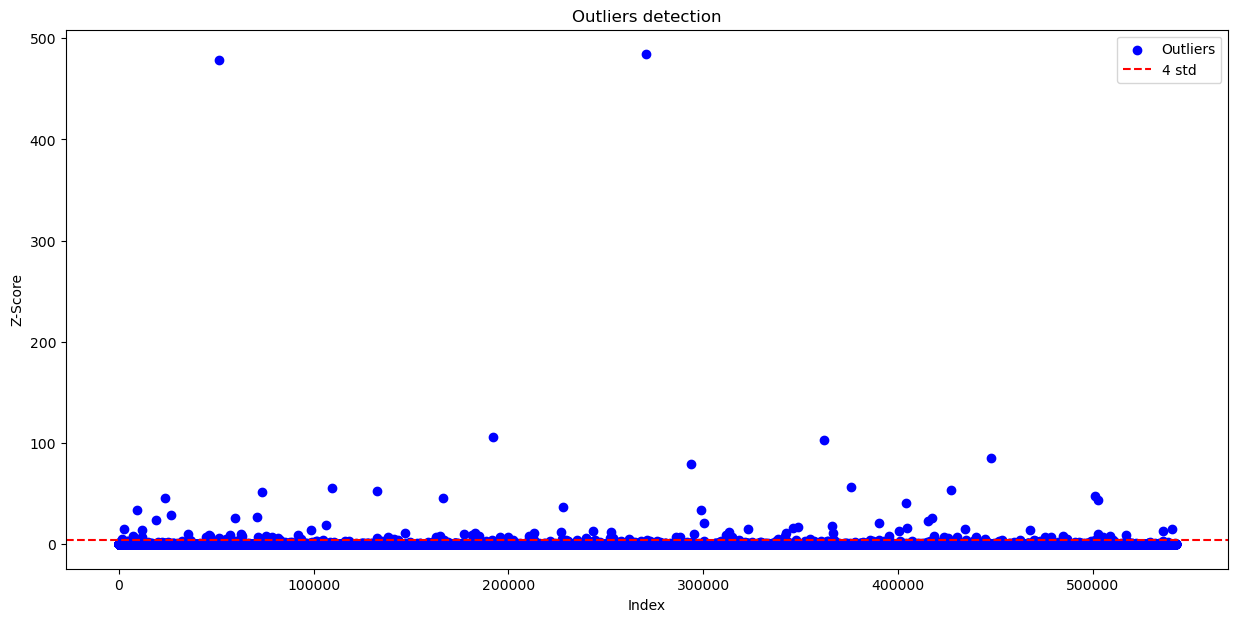

In [23]:
# Fit the model
model = sm.OLS(y_train_scaled, sm.add_constant(X_train_preprocessed))

# Get the predictions
predictions = model.fit().predict(sm.add_constant(X_train_preprocessed))

# Calculate the residuals
residuals = y_train_scaled - predictions

# Calculate the z-scores
z_scores = np.abs((residuals - residuals.mean()) / residuals.std())

# Get the indices of the outliers
outliers = np.where(z_scores > 4)[0]

# Plot outliers
plt.figure(figsize=(15, 7))
plt.scatter(range(len(z_scores)), z_scores, color='blue', label='Outliers')
plt.axhline(y=4, color='red', linestyle='--', label='4 std')
plt.title('Outliers detection')
plt.xlabel('Index')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

We keep the outliers and don't remove them as they might be important for the model. However, we will scale the data to make the model more robust to outliers. Removing outliers from the training set might increase the model training performacne, however it might decrease the model performance on the test set. We try to further overcome the problem by using a propper performance metric.

### Feature Selection

As the dataset has a high dimensionality, we will perform feature selection to select the most important features for the model. We will use the feature importance of a Random Forest Regressor to select the most important features. We can see that some Region categories are important for the model, which is surprising as we saw in the EDA that the Region feature has a low disparity in claims amount. We will keep the feature for now and see if it improves the model performance. 

Later, we train the models on both the full dataset and the selected features to compare the performances.

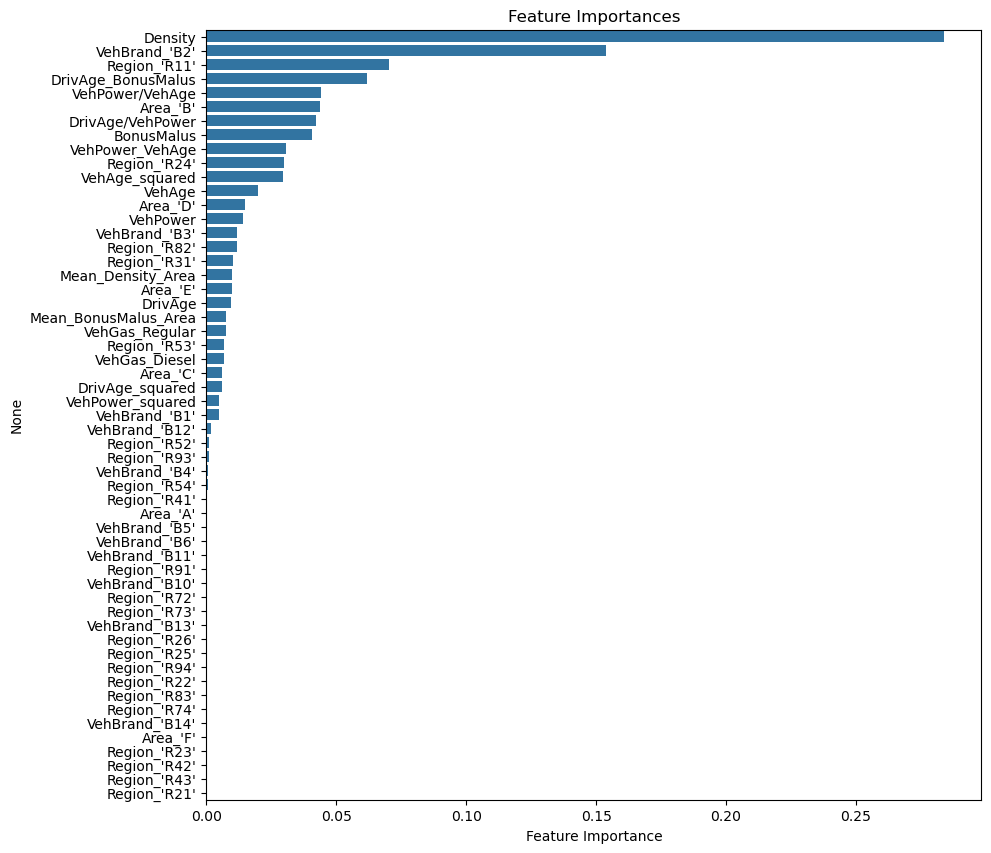

In [24]:
# Use RF to get the feature importances
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_preprocessed, y_train_scaled)

# Get the feature importances
feature_importances = rf.feature_importances_

feature_names = numerical_columns.tolist() + preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_vars).tolist()

# Create a DataFrame with the feature importances
feature_importances_df = pd.DataFrame(data=feature_importances, index=feature_names, columns=['Feature Importance'])

# Sort the DataFrame in descending order
feature_importances_df = feature_importances_df.sort_values(by='Feature Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='Feature Importance', y=feature_importances_df.index, data=feature_importances_df)
plt.title('Feature Importances')
plt.show()

In [39]:
# select features with importance > 0
selected_features = feature_importances_df[feature_importances_df['Feature Importance'] > 0.01].index.tolist()

# Get the indices of the selected features
selected_features_indices = [feature_names.index(feature) for feature in selected_features]

# Select the features
X_train_preprocessed_selected = X_train_preprocessed[:, selected_features_indices]
X_test_preprocessed_selected = X_test_preprocessed[:, selected_features_indices]

In [40]:
selected_features

['Density',
 "VehBrand_'B2'",
 "Region_'R11'",
 'DrivAge_BonusMalus',
 'VehPower/VehAge',
 "Area_'B'",
 'DrivAge/VehPower',
 'BonusMalus',
 'VehPower_VehAge',
 "Region_'R24'",
 'VehAge_squared',
 'VehAge',
 "Area_'D'",
 'VehPower',
 "VehBrand_'B3'",
 "Region_'R82'",
 "Region_'R31'",
 'Mean_Density_Area']

### Feature Selection Observations

It can be seen that some features have a very low importance and could be removed from the dataset. This especially holds true for some one-hot encoded features. We keep features with a importane higher than 0.01.

## Model Selection 

In this step, we will select the best model to predict the claims amount. We will use the Mean Absolute Error (MAE) as the evaluation metric as it is more robust to outliers than the Mean Squared Error (MSE). Further we use the full dataset and the selected features dataset to train the models and compare the performance.

We will evaluate the following models.

1. Generalized Linear Model (GLM): As this is typical for insurance data modelling.
2. LightGBM: As it is a powerful tree-based model that can handle high-dimensional data.
3. XGBoost: As it is a powerful tree-based model that uses regularization to prevent overfitting.

### Model Training

In [41]:
# Model Building
datasets = {"all_features": (X_train_preprocessed, X_test_preprocessed), "selected_features": (X_train_preprocessed_selected, X_test_preprocessed_selected)}

models = {"all_features": [], "selected_features": []}
for key, value in datasets.items():
    
    # GLM
    model_smf = smf.glm(formula='LossRatio ~ ' + ' + '.join(list(X.columns)), data=pd.concat([X_train, y_train], axis=1), family=sm.families.Poisson()).fit()

    # LightGBM
    model_lgbm = LGBMRegressor(
        random_state=42,
        learning_rate=0.01,
        max_depth=5,
        metric='mae',
        verbose = -1
    )
    model_lgbm.fit(value[0], y_train_scaled)

    # XGBoost
    model_xgb = XGBRegressor(
        random_state=42, 
        learning_rate=0.01,
        max_depth=5,
        eval_metric='mae'
    )
    model_xgb.fit(value[0], y_train_scaled)

    models[key].append(model_smf)
    models[key].append(model_lgbm)
    models[key].append(model_xgb)


In [57]:
# save the models for later use
model_smf_params = model_smf.params
model_smf_params.to_pickle('models/model_smf.pkl')
torch.save(model_lgbm, 'models/model_lgbm.pkl')
torch.save(model_xgb, 'models/model_xgb.pkl')

### Model Evaluation

Using all_features dataset
Train Score (GLM): 718.3634365193366, Test Score (GLM): 761.8858278939462
Train Score (LightGBM): 723.023507970864, Test Score (LightGBM): 778.9242353139829
Train Score (XGBoost): 686.3652341529854, Test Score (XGBoost): 861.4559491859629


Using selected_features dataset
Train Score (GLM): 718.3634365193366, Test Score (GLM): 761.8858278939462
Train Score (LightGBM): 725.6397297615758, Test Score (LightGBM): 772.9885642297791
Train Score (XGBoost): 682.3446600173165, Test Score (XGBoost): 741.2067152460596




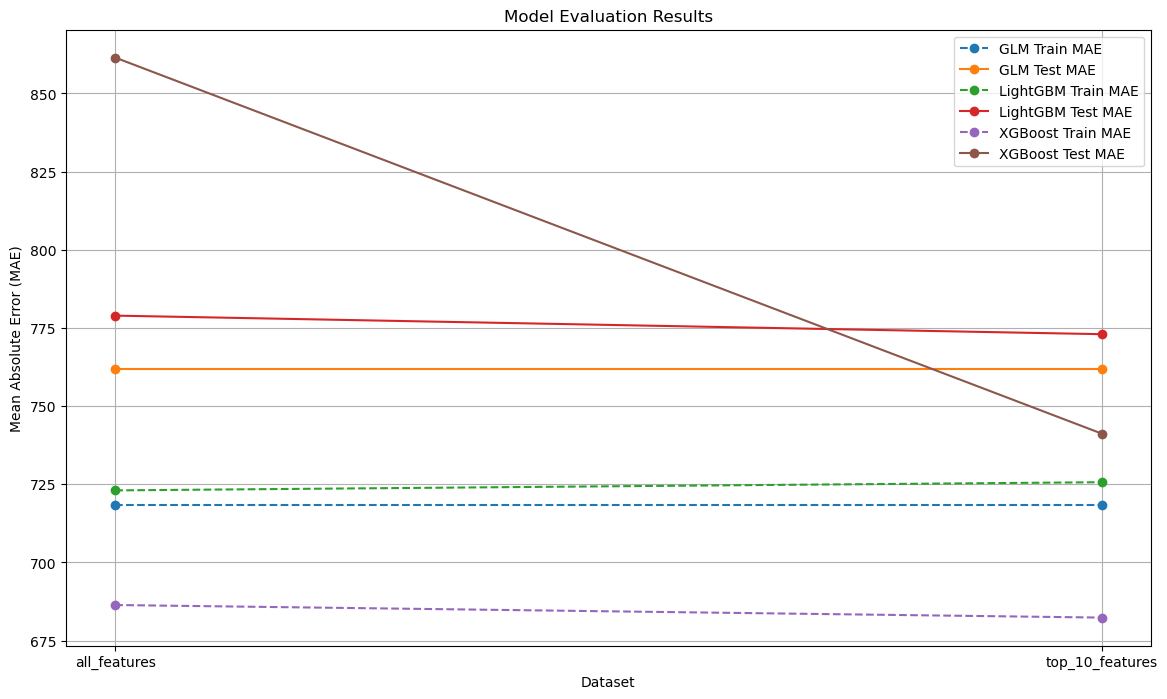

In [52]:
# Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, scaler=None):
    # Predict the target variable
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    if scaler:
        y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
        y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    # Calculate MAE
    train_score = np.mean(np.abs(y_train - y_train_pred))
    test_score = np.mean(np.abs(y_test - y_test_pred))
    
    
    return train_score, test_score

# Initialize dictionaries to store the results
results_train = {'GLM': [], 'LightGBM': [], 'XGBoost': []}
results_test = {'GLM': [], 'LightGBM': [], 'XGBoost': []}
datasets = []

# Loop through the models and datasets to evaluate and store the results
for key, value in models.items():

    print(f"Using {key} dataset")
    model_smf = value[0]
    model_lgbm = value[1]
    model_xgb = value[2]

    if key == "all_features":
        train_score_smf, test_score_smf = evaluate_model(model_smf, X_train, y_train, X_test, y_test)
        train_score_lgbm, test_score_lgbm = evaluate_model(model_lgbm, X_train_preprocessed, y_train_scaled, X_test_preprocessed, y_test_scaled, scaler=scaler)
        train_score_xgb, test_score_xgb = evaluate_model(model_xgb, X_train_preprocessed, y_train_scaled, X_test_preprocessed, y_test_scaled, scaler=scaler)
    else:
        train_score_smf, test_score_smf = evaluate_model(model_smf, X_train, y_train, X_test, y_test)
        train_score_lgbm, test_score_lgbm = evaluate_model(model_lgbm, X_train_preprocessed_selected, y_train_scaled, X_test_preprocessed_selected, y_test_scaled, scaler=scaler)
        train_score_xgb, test_score_xgb = evaluate_model(model_xgb, X_train_preprocessed_selected, y_train_scaled, X_test_preprocessed_selected, y_test_scaled, scaler=scaler)
    
    # Store the results
    results_train['GLM'].append(train_score_smf)
    results_test['GLM'].append(test_score_smf)
    results_train['LightGBM'].append(train_score_lgbm)
    results_test['LightGBM'].append(test_score_lgbm)
    results_train['XGBoost'].append(train_score_xgb)
    results_test['XGBoost'].append(test_score_xgb)
    datasets.append(key)

    # Print the evaluation results
    print(f"Train Score (GLM): {train_score_smf}, Test Score (GLM): {test_score_smf}")
    print(f"Train Score (LightGBM): {train_score_lgbm}, Test Score (LightGBM): {test_score_lgbm}")
    print(f"Train Score (XGBoost): {train_score_xgb}, Test Score (XGBoost): {test_score_xgb}")
    print("\n")

# Plotting the results
plt.figure(figsize=(14, 8))

# Plot for GLM
plt.plot(datasets, results_train['GLM'], label='GLM Train MAE', marker='o', linestyle='--')
plt.plot(datasets, results_test['GLM'], label='GLM Test MAE', marker='o')

# Plot for LightGBM
plt.plot(datasets, results_train['LightGBM'], label='LightGBM Train MAE', marker='o', linestyle='--')
plt.plot(datasets, results_test['LightGBM'], label='LightGBM Test MAE', marker='o')

# Plot for XGBoost
plt.plot(datasets, results_train['XGBoost'], label='XGBoost Train MAE', marker='o', linestyle='--')
plt.plot(datasets, results_test['XGBoost'], label='XGBoost Test MAE', marker='o')

# Adding labels and title
plt.xlabel('Dataset')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Evaluation Results')
plt.legend()
plt.grid(True)
plt.show()


### Model Selection Results
 1. Best Model on test set: XGBoost with the selected features dataset. With full dataset it overfits and performs worse than the other models.
 
 2. No significant differences between selected features and full dataset for other models.
 3. Suprisingly GLM outperforms LightGBM on both datasets. This might be due to bad hyperparameters for LightGBM.
 
  
We move forward with the XGBoost model trained on the selected features dataset as it has the best performance on the test set. 

# Hyperparameter Tuning

Finally we use cross-validation to tune the hyperparameters of the best model (xgboost). We will use the following hyperparameters for tuning setup:

In [44]:
# Hyperparameter Tuning for xgBoost

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 5),
    'learning_rate': stats.uniform(0.001, 0.1),
    'n_estimators': stats.randint(100, 1000),
    'subsample': stats.uniform(0.6, 0.4),  # Range from 0.6 to 1.0
    'colsample_bytree': stats.uniform(0.6, 0.4),  # Range from 0.6 to 1.0
    'reg_alpha': stats.uniform(0, 0.1),  # L1 regularization term
    'reg_lambda': stats.uniform(0.8, 1.2),  # L2 regularization term
    'gamma': stats.uniform(0, 0.5),  # Minimum loss reduction
}

random_search = RandomizedSearchCV(XGBRegressor(random_state=42, verbose=1), param_distributions=param_dist, n_iter=50, cv=10, scoring='neg_mean_absolute_error',)


# Fit the GridSearchCV object
random_search.fit(X_train_preprocessed_selected, y_train_scaled)

# Get the best parameters
best_params = random_search.best_params_

# Initialize the XGBoost model with the best parameters
model_xgb_tuned = XGBRegressor(
    random_state=42,
    **best_params,
    verbosity=0,
    eval_metric='mae'
)

# Fit the model
model_xgb_tuned.fit(X_train_preprocessed_selected, y_train_scaled)

# Get the evaluation results
train_score_xgb_tuned, test_score_xgb_tuned = evaluate_model(model_xgb_tuned, X_train_preprocessed_selected, y_train_scaled, X_test_preprocessed_selected, y_test_scaled, scaler=scaler)

# Print the evaluation results
print(f"Train Score (XGBoost Tuned): {train_score_xgb_tuned}, Test Score (XGBoost Tuned): {test_score_xgb_tuned}")

Train Score (XGBoost Tuned): 553.8090426449045, Test Score (XGBoost Tuned): 822.9899161822976


In [48]:
print("Best parameters for XGBoost: ", best_params)

Best parameters for XGBoost:  {'colsample_bytree': 0.9831677975026685, 'gamma': 0.13227905007708352, 'learning_rate': 0.03070264117397077, 'max_depth': 8, 'n_estimators': 225, 'reg_alpha': 0.01858775213443045, 'reg_lambda': 1.7767800558045344, 'subsample': 0.9744773793129122}


In [55]:
# save the tuned model for later use
torch.save(model_xgb_tuned, 'models/model_xgb_tuned.pkl')

### Results Hyperparameter Tuning

Hyperparameter tuning lead to overfitting even when used cross-validation. We will use the default hyperparameters for the final model. Further research on the hyperparameters might be necessary to improve the model performance.

## Feature Importance

In a last step we will look at the feature importance of the best model (default xgBoost) to understand which features are important for predicting the claims amount.

Text(0.5, 1.0, 'Feature Importances')

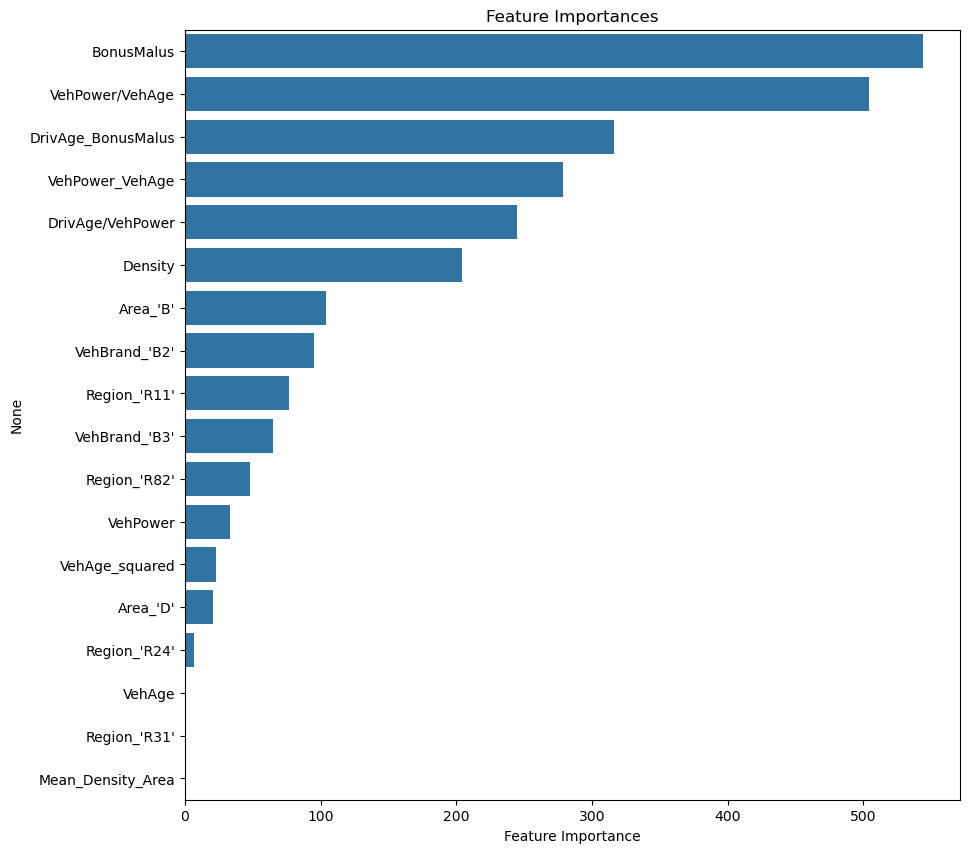

In [50]:
# Get the feature importances
feature_importances_tuned = models["selected_features"][1].feature_importances_

# Create a DataFrame with the feature importances
feature_importances_df_tuned = pd.DataFrame(data=feature_importances_tuned, index=selected_features, columns=['Feature Importance'])

# Sort the DataFrame in descending order
feature_importances_df_tuned = feature_importances_df_tuned.sort_values(by='Feature Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='Feature Importance', y=feature_importances_df_tuned.index, data=feature_importances_df_tuned)
plt.title('Feature Importances')

Features about the driver such as the age and the BonusMalus play a big role. Furthermore the vehicle power is an important feature for the model. Regional features such as area, density and region are further important features for the model. Hence it was a good idea to keep the region feature in the dataset as some regions have a high importance.

## Summary and Future Outlook

The XGBoost model trained on the selected features dataset is the best model to predict the claims amount. The model has a Mean Absolute Error of 741.2€ on the test set, which is a good performance given the distribution of the target variable.

Further improvements can be made by ...
1. ... applying better Feature Enginnering (e.g. creating new features, grouping categories, etc.)
2. ... tuning the hyperparameters of each model & try different optimization algorithms such as Bayesian Optimization.
3. ... trying different models such as Neural Networks to see if they can improve the performance
4. ... preventing overfitting when tuning the hyperparameters of xgBoost.